# ElectroStatic Potential Field

## Units

- Distance: $Å$
- Charge: $e$
- Dipole: $eÅ$ or $D=0.2081943 \; eÅ$
- Potential: $V$
- Potential / Coulomb constant: $e/Å$

## Imports

In [1]:
%matplotlib widget

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import sys
sys.path.append('../src/')
import constants
import read
import espf
from fireball import FireballResults
from vdwsurface import vdw_surface

## Read and check input

In [2]:
icluster1 = FireballResults("icluster1")

In [3]:
print(icluster1.rqs)

[[ 0.          0.          0.40793333]
 [ 0.          0.7654     -0.20396667]
 [ 0.         -0.7654     -0.20396667]]


In [4]:
print(espf.compute_dipole(icluster1.rqs, icluster1.q4s))
print(espf.compute_dipole(icluster1.rqs, icluster1.q7s))

[ 0.00000000e+00 -1.19744190e-08 -1.05373444e+00]
[ 0.00000000e+00  4.25720370e-09 -1.69196561e+00]


In [5]:
print("Dipolo original: ", icluster1.totaldips[0])
rqdip, qdip = espf.dipole2charges(icluster1.rqs[0], icluster1.totaldips[0], d=1)
print("Posiciones: ", rqdip)
print("Cargas: ", qdip)
print("Dipolo reconstruído: ", espf.compute_dipole(rqdip, qdip))

Dipolo original:  [-0.      0.     -0.5824]
Posiciones:  [[ 0.          0.          0.90793333]
 [ 0.          0.         -0.09206667]]
Cargas:  [-0.12125236  0.12125236]
Dipolo reconstruído:  [ 0.      0.     -0.5824]


In [6]:
# Check how big is VdW surface (scaled by 2)
vdw = []
for s, p in zip(icluster1.symbols, icluster1.rqs):
    vdw.append(p - 2*constants.BONDI_RADII[s])
    vdw.append(p + 2*constants.BONDI_RADII[s])
vdw = np.array(vdw)
min = np.min(vdw, axis=0)
max = np.max(vdw, axis=0)
print(min)
print(max)
print(icluster1.minilvs/2)

[-3.04       -3.1654     -2.63206667]
[3.04       3.1654     3.44793333]
[[3.911285 0.       0.      ]
 [0.       3.911285 0.      ]
 [0.       0.       3.911285]]


## Along 1D axis

(-0.7, 0.5)

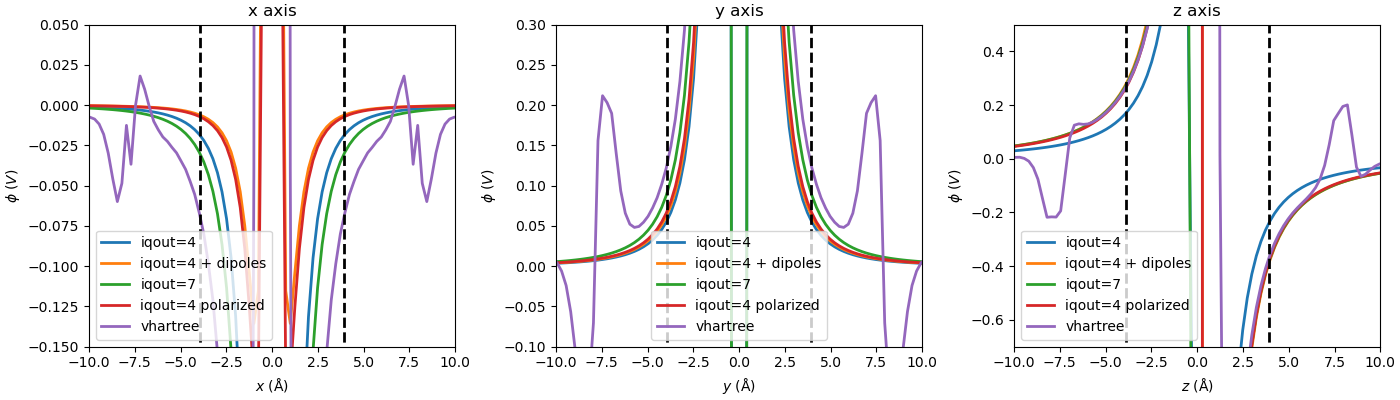

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), layout='constrained')

directions = [np.array([1.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]), np.array([0.0, 0.0, 1.0])]
def midslice(object, dim):
    index = (np.array(object.shape) - 1)/2                                                                     
    index = index.astype(int)
    index = list(index)
    index[dim] = slice(None, None, None)
    index = tuple(index)
    return object[index]

for dim in range(3):
    rs = np.array([r*directions[dim] for r in icluster1.grid3d[dim]])
    axs[dim].plot(rs[:, dim], espf.pointcharges_espf(icluster1.rqs, icluster1.q4s, rs), lw=2, label="iqout=4")
    axs[dim].plot(rs[:, dim], espf.pointcharges_espf(icluster1.rqs, icluster1.q4s, rs) + espf.dipoles_espf(icluster1.rqs, icluster1.totaldips, rs), lw=2, label="iqout=4 + dipoles")
    axs[dim].plot(rs[:, dim], espf.pointcharges_espf(icluster1.rqs, icluster1.q7s, rs), lw=2, label="iqout=7")

    rqdips, qdips = espf.dipole2charges(icluster1.rqs[0], icluster1.totaldips[0], d=0.01)
    axs[dim].plot(rs[:, dim], espf.pointcharges_espf(icluster1.rqs, icluster1.q4s, rs) + espf.pointcharges_espf(rqdips, qdips, rs), lw=2, label="iqout=4 polarized")
    
    axs[dim].plot(rs[:, dim], midslice(icluster1.vhartree3d, dim), lw=2, label="vhartree")
    
    axs[dim].plot([icluster1.minilvs[dim, dim]/2, icluster1.minilvs[dim, dim]/2], [-10, 10], 'k--', lw=2)
    axs[dim].plot([-icluster1.minilvs[dim, dim]/2, -icluster1.minilvs[dim, dim]/2], [-10, 10], 'k--', lw=2)
    axs[dim].set_ylabel("$\phi$ ($V$)")
    axs[dim].legend()

axs[0].set_title("x axis")
axs[0].set_xlabel("$x$ (Å)")
axs[1].set_title("y axis")
axs[1].set_xlabel("$y$ (Å)")
axs[2].set_title("z axis")
axs[2].set_xlabel("$z$ (Å)")

axs[0].set_xlim(-10, 10)
axs[0].set_ylim(-0.15, 0.05)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-0.1, 0.3)
axs[2].set_xlim(-10, 10)
axs[2].set_ylim(-0.7, 0.5)

## On 2D plane

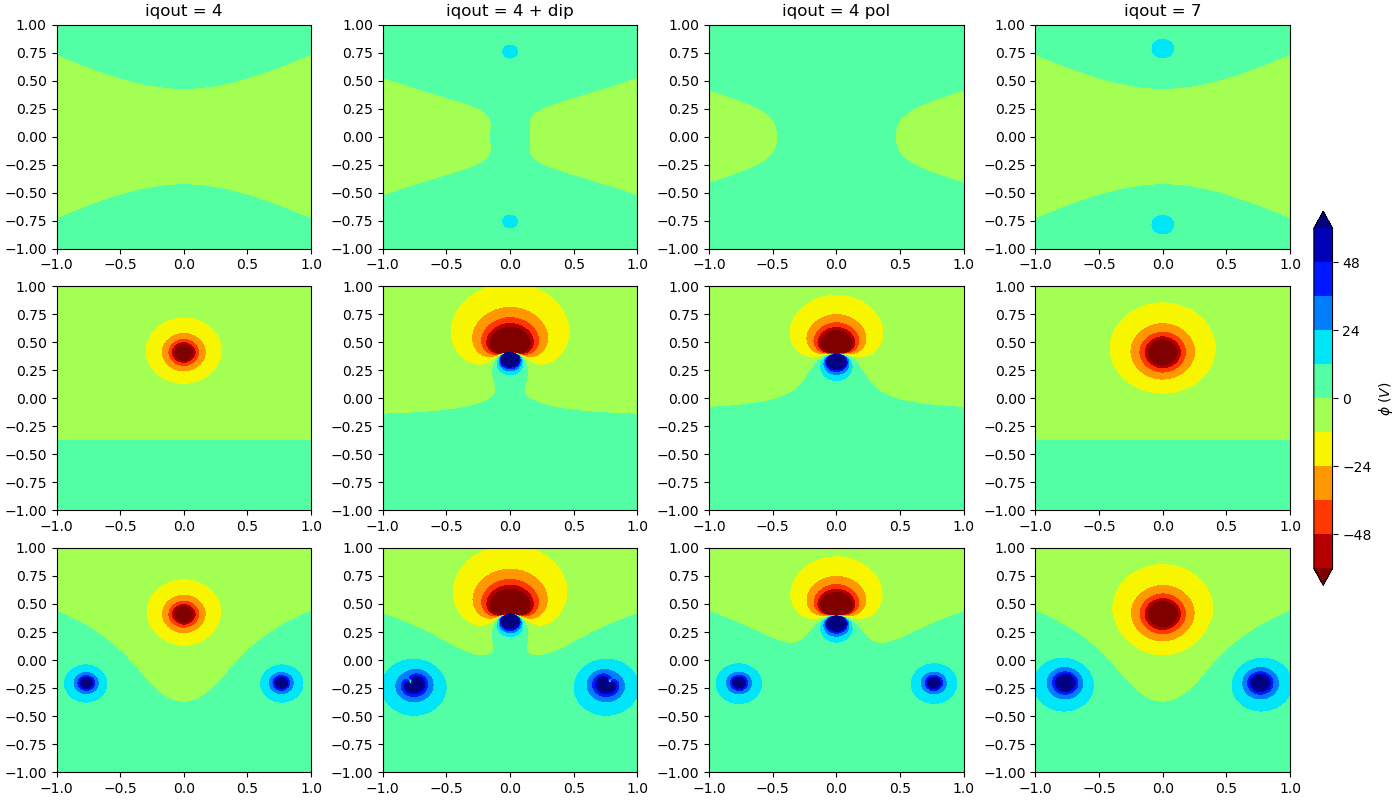

In [8]:
def espfq7(icluster, rs): return espf.pointcharges_espf(icluster.rqs, icluster.q7s, rs)
def espfq4(icluster, rs): return espf.pointcharges_espf(icluster.rqs, icluster.q4s, rs)
def espfq4dip(icluster, rs): return espf.pointcharges_espf(icluster.rqs, icluster.q7s, rs) + espf.dipoles_espf(icluster.rqs, icluster.totaldips, rs)
d_test = 0.1
def espfq4pol(icluster, rs):
    rqdips, qdips = espf.dipole2charges(icluster.rqs[0], icluster.intradips[0], d=d_test)
    return espf.pointcharges_espf(icluster.rqs, icluster.q4s, rs) + espf.pointcharges_espf(rqdips, qdips, rs)
espfs = [espfq4, espfq4dip, espfq4pol, espfq7]
titles = ["iqout = 4", "iqout = 4 + dip",  "iqout = 4 pol", "iqout = 7"]

fig, axs = plt.subplots(3, len(espfs), figsize=(14, 8), layout='constrained')
levels = np.linspace(-60, 60, 11)

for i in range(len(espfs)):
    xs = np.linspace(-1, 1, 101)
    ys = np.linspace(-1, 1, 101)
    rs = np.array([np.array([x, y, 0]) for y in ys for x in xs])
    axs[0, i].contourf(xs, ys, np.reshape(espfs[i](icluster1, rs), (-1, 101)), levels, cmap=mpl.cm.jet_r, extend='both')
    axs[0, i].set_title(titles[i])
    
    xs = np.linspace(-1, 1, 101)
    zs = np.linspace(-1, 1, 101)
    rs = np.array([np.array([x, 0, z]) for z in zs for x in xs])
    axs[1, i].contourf(xs, zs, np.reshape(espfs[i](icluster1, rs), (-1, 101)), levels, cmap=mpl.cm.jet_r, extend='both')
    
    ys = np.linspace(-1, 1, 101)
    zs = np.linspace(-1, 1, 101)
    rs = np.array([np.array([0, y, z]) for z in zs for y in ys])
    cf = axs[2, i].contourf(ys, zs, np.reshape(espfs[i](icluster1, rs), (-1, 101)), levels, cmap=mpl.cm.jet_r, extend='both')

fig.colorbar(cf, ax=axs[:, -1], shrink=0.5, label="$\phi$ ($V$)")

## In 3D space

In [9]:
points, mesh = vdw_surface(icluster1.rqs, icluster1.symbols, density=100, scale_factor=1.0) # 1.4, 1.6, 1.8, and 2.0.
points_4layers = np.concatenate((vdw_surface(icluster1.rqs, icluster1.symbols, density=100, scale_factor=1.4)[0],
                                 vdw_surface(icluster1.rqs, icluster1.symbols, density=100, scale_factor=1.6)[0],
                                 vdw_surface(icluster1.rqs, icluster1.symbols, density=100, scale_factor=1.8)[0],
                                 vdw_surface(icluster1.rqs, icluster1.symbols, density=100, scale_factor=2.0)[0]))

[-0.58353627  0.29176814  0.29176814]


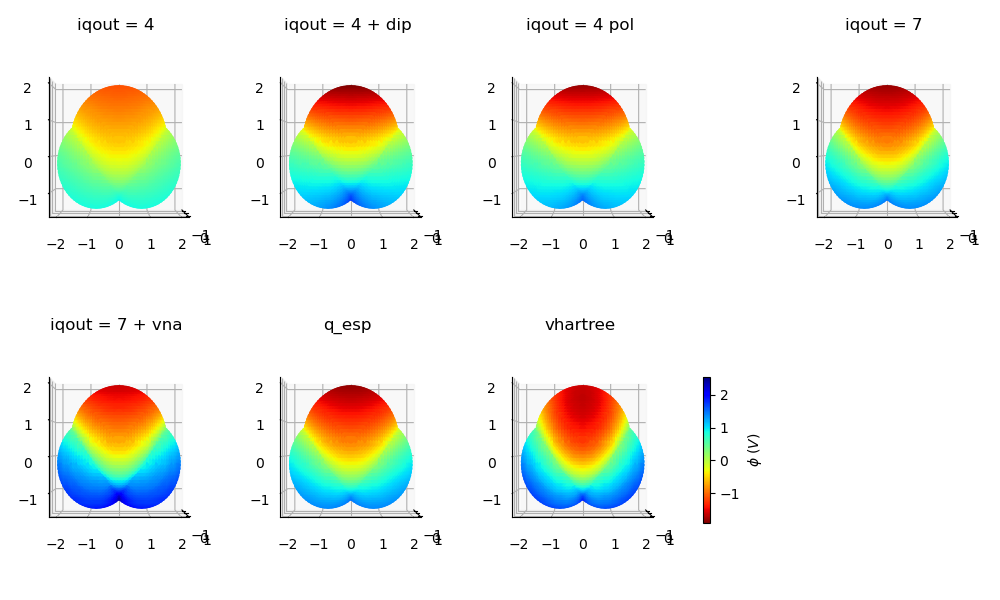

In [10]:
fig = plt.figure(figsize=(10, 6), layout='constrained')

espf_q4 = espf.pointcharges_espf(icluster1.rqs, icluster1.q4s, points)
espf_q4dip = (espf.pointcharges_espf(icluster1.rqs, icluster1.q4s, points) + espf.dipoles_espf(icluster1.rqs, icluster1.totaldips, points))
espf_q7 = espf.pointcharges_espf(icluster1.rqs, icluster1.q7s, points)
espf_q7vna = espf.pointcharges_espf(icluster1.rqs, icluster1.q7s, points) + espf.interpolate_espf(icluster1.grid3d, icluster1.vna3d, points)
espf_vhartree = espf.interpolate_espf(icluster1.grid3d, icluster1.vhartree3d, points)

d_test = 0.1
rqdips, qdips = espf.dipole2charges(icluster1.rqs[0], icluster1.intradips[0], d=d_test)
espf_q4pol = espf.pointcharges_espf(icluster1.rqs, icluster1.q4s, points) + espf.pointcharges_espf(rqdips, qdips, points)

espf_vhartree_4layers = espf.interpolate_espf(icluster1.grid3d, icluster1.vhartree3d, points_4layers)
qesps = espf.compute_espcharges(icluster1.rqs, points_4layers, espf_vhartree_4layers)
print(qesps)
espf_qesp = espf.pointcharges_espf(icluster1.rqs, qesps, points)

espfs = [espf_q4, espf_q4dip, espf_q4pol, espf_q7, espf_q7vna, espf_qesp, espf_vhartree]
titles = ["iqout = 4", "iqout = 4 + dip", "iqout = 4 pol", "iqout = 7", "iqout = 7 + vna", "q_esp", "vhartree"]

allvalues = np.concatenate(espfs)
min, max = allvalues.min(), allvalues.max()
norm = plt.Normalize(min, max)

for i in range(len(espfs)):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    s = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=espfs[i], cmap=mpl.cm.jet_r, norm=norm)
    ax.set_title(titles[i])
    ax.set_box_aspect([1,1,1])
    ax.view_init(0, 0, 0)

fig.colorbar(s, shrink=0.5, label="$\phi$ ($V$)")

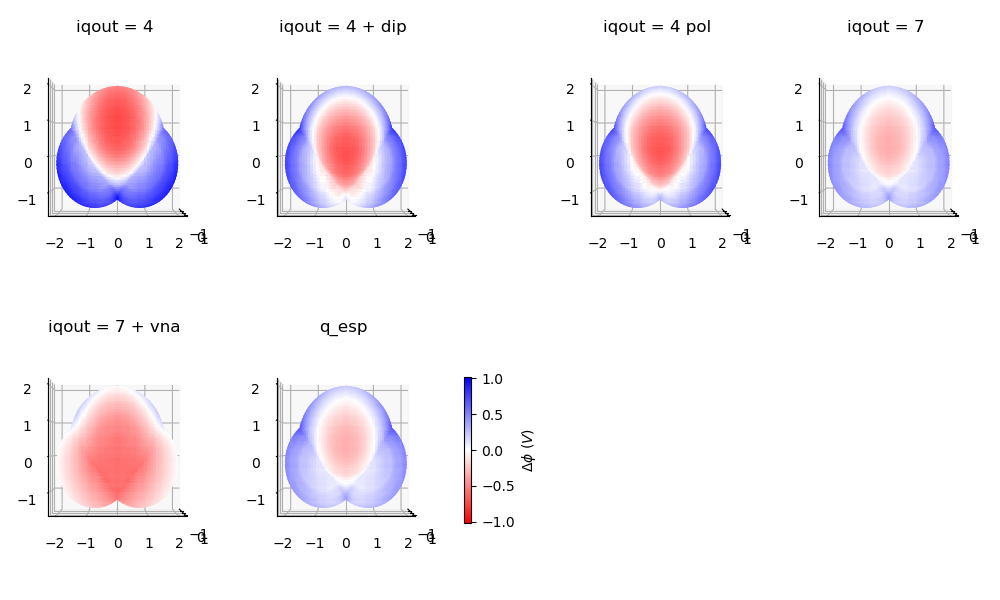

In [11]:
fig = plt.figure(figsize=(10, 6), layout='constrained')

d_espfs = [espf_vhartree-espf_ for espf_ in espfs[:-1]]

allvalues = np.concatenate(d_espfs)
min, max = -np.absolute(allvalues).max(), np.absolute(allvalues).max()
norm = plt.Normalize(min, max)

for i in range(len(d_espfs)):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    s = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=d_espfs[i], cmap=mpl.cm.bwr_r, norm=norm)
    ax.set_title(titles[i])
    ax.set_box_aspect([1,1,1])
    ax.view_init(0, 0, 0)

fig.colorbar(s, shrink=0.5, label="$\Delta\phi$ ($V$)")

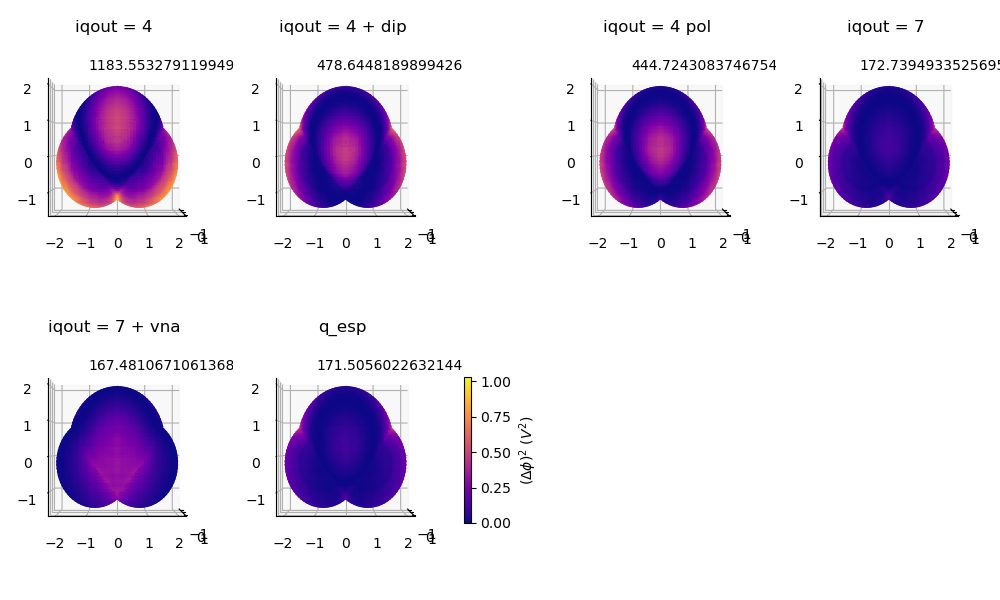

In [12]:
fig = plt.figure(figsize=(10, 6), layout='constrained')

espf_q4_4layers = espf.pointcharges_espf(icluster1.rqs, icluster1.q4s, points_4layers)
espf_q4dip_4layers = (espf.pointcharges_espf(icluster1.rqs, icluster1.q4s, points_4layers) + espf.dipoles_espf(icluster1.rqs, icluster1.totaldips, points_4layers))
espf_q7_4layers = espf.pointcharges_espf(icluster1.rqs, icluster1.q7s, points_4layers)
espf_q7vna_4layers = espf.pointcharges_espf(icluster1.rqs, icluster1.q7s, points_4layers) + espf.interpolate_espf(icluster1.grid3d, icluster1.vna3d, points_4layers)
espf_qesp_4layers = espf.pointcharges_espf(icluster1.rqs, qesps, points_4layers)

espf_q4pol_4layers = espf.pointcharges_espf(icluster1.rqs, icluster1.q4s, points_4layers) + espf.pointcharges_espf(rqdips, qdips, points_4layers)

espfs_4layers = [espf_q4_4layers, espf_q4dip_4layers, espf_q4pol_4layers, espf_q7_4layers, espf_q7vna_4layers, espf_qesp_4layers]
d_espfs_2 = [(espf_vhartree-espf_)**2 for espf_ in espfs[:-1]]

allvalues = np.concatenate(d_espfs_2)
min, max = 0, np.absolute(allvalues).max()
norm = plt.Normalize(min, max)

for i in range(len(d_espfs_2)):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    s = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=d_espfs_2[i], cmap=mpl.cm.plasma, norm=norm)
    ax.text(0, -1, 2.5, np.sum((espfs_4layers[i]-espf_vhartree_4layers)**2))
    ax.set_title(titles[i])
    ax.set_box_aspect([1,1,1])
    ax.view_init(0, 0, 0)

fig.colorbar(s, shrink=0.5, label="$(\Delta\phi)^2$ ($V^2$)")

## Dev testing